In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot  as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import category_encoders as ce

In [16]:
df_t=pd.read_csv("/Training Data.csv")
df_T=pd.read_csv("/Test Data.csv")

In [25]:
df_T=df_T.drop(columns='Unnamed: 0')

In [26]:
df_T.columns

Index(['user_id', 'aov', 'category'], dtype='object')

In [27]:
df_t=(df_T.groupby(by=['user_id','category'])['aov'].sum().reset_index())
df_t

,user_id,category,aov
0,2,Ereaders,7696.0
1,2,Fashion,1165.0
2,2,Fitness,7035.0
3,2,Phones,36551.0
4,3,Consumer Durables,23785.0
...,...,...,...
107058,50037,Groceries,1729.0
107059,50050,Back to School,315.0
107060,50050,Groceries,1352.0
107061,50074,Kitchen cleaning Supplies,222.0


In [28]:
table1=pd.pivot_table(df_T,index=['user_id','category'],aggfunc='count')
table1

aov
user_id category                      
2       Ereaders                     1
        Fashion                      2
        Fitness                      1
        Phones                       2
3       Consumer Durables            1
...                                ...
50037   Groceries                    1
50050   Back to School               1
        Groceries                    1
50074   Kitchen cleaning Supplies    1
50089   Back to School               1

[107063 rows x 1 columns]

In [29]:
product=pd.unique(df_t.category)
user_id=pd.unique(df_t.user_id)
print(user_id,product)
len(product),len(user_id)

[    2     3     8 ... 50050 50074 50089] ['Ereaders' 'Fashion' 'Fitness' 'Phones' 'Consumer Durables' 'Toys'
 'Back to School' 'Home Decor' 'Laptops' 'Books' 'Groceries'
 'Pet Supplies' 'Gaming' 'Beauty Products' 'Board Games'
 'Painiting Supplies' 'Kitchen cleaning Supplies' 'TVs']


(18, 19981)

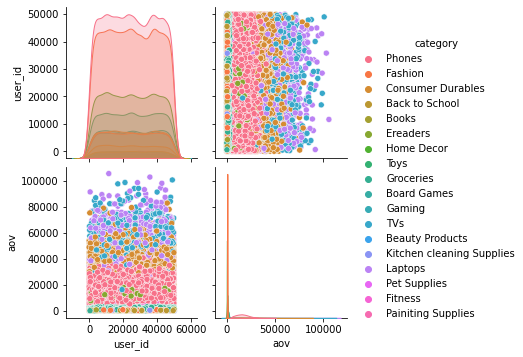

In [30]:
sns.pairplot(df_T,hue='category')

In [31]:
combine_order_rate=df_T.dropna(axis = 0, subset = ['category'])

product_orderCount = (combine_order_rate.
     groupby(by = ['category'])['aov'].
     count().
     reset_index().
     rename(columns = {'aov': 'totalOrderCount'})
     [['category', 'totalOrderCount']]
    )
product_orderCount.head(10)

,category,totalOrderCount
0,Back to School,8405
1,Beauty Products,2055
2,Board Games,1981
3,Books,3968
4,Consumer Durables,7984
5,Ereaders,2163
6,Fashion,40082
7,Fitness,1961
8,Gaming,8109
9,Groceries,8559


In [33]:
product_with_totalOrderCount = combine_order_rate.merge(product_orderCount, left_on = 'category', right_on = 'category', how = 'left')
product_with_totalOrderCount.tail(10)

,user_id,aov,category,totalOrderCount
172544,4260,896.0,Books,3968
172545,49488,330.0,Back to School,8405
172546,39778,975.0,Fashion,40082
172547,36793,2868.0,Groceries,8559
172548,42131,647.0,Back to School,8405
172549,12403,1841.0,Groceries,8559
172550,31036,424.0,Back to School,8405
172551,12652,617.0,Fashion,40082
172552,35726,634.0,Kitchen cleaning Supplies,2042
172553,19871,994.0,Fashion,40082


In [34]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
print(product_orderCount['totalOrderCount'].describe())

count      18.0
mean     9586.3
std     12971.9
min      1255.0
25%      2000.8
50%      3065.5
75%      8520.5
max     44627.0
Name: totalOrderCount, dtype: float64


In [35]:
popularity_threshold = round(product_orderCount['totalOrderCount'].mean()/18)
rating_popular_product= product_with_totalOrderCount.query('totalOrderCount >= @popularity_threshold')
rating_popular_product.head()

,user_id,aov,category,totalOrderCount
0,43323,19115.0,Phones,44627
1,43323,29309.0,Phones,44627
2,43323,15293.0,Phones,44627
3,43323,23548.0,Phones,44627
4,43323,751.0,Fashion,40082


In [36]:
rating_popular_product.shape

(172554, 4)

In [37]:
product_features_df=rating_popular_product.pivot_table(index='category',columns='user_id',values='aov').fillna(0)
product_features_df.head(18)

user_id,2,3,8,10,13,15,17,18,20,22,...,49987,49989,49994,49995,49997,49998,50037,50050,50074,50089
category,,,,,,,,,,,,,,,,,,,,,
Back to School,0.0,0.0,763.0,0.0,711.0,0.0,694.0,0.0,574.5,482.0,...,0.0,522.0,0.0,332.0,0.0,0.0,0.0,315.0,0.0,949.0
Beauty Products,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Board Games,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Books,0.0,0.0,0.0,0.0,346.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,386.0,600.0,0.0,0.0,0.0,0.0,0.0
Consumer Durables,0.0,23785.0,29859.0,0.0,18990.0,0.0,31846.0,0.0,0.0,0.0,...,12000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ereaders,7696.0,8572.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11331.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fashion,582.5,561.0,733.5,681.0,597.0,666.7,719.4,934.3,820.0,896.5,...,622.3,0.0,0.0,645.7,803.0,572.5,0.0,0.0,0.0,0.0
Fitness,7035.0,0.0,2150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gaming,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1760.0,2594.0,0.0,...,0.0,0.0,0.0,391.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
from scipy.sparse import csr_matrix

product_features_df_matrix = csr_matrix(product_features_df.values)
#print(product_features_df_matrix)
from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(product_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [39]:
product_features_df.head(18)

user_id,2,3,8,10,13,15,17,18,20,22,...,49987,49989,49994,49995,49997,49998,50037,50050,50074,50089
category,,,,,,,,,,,,,,,,,,,,,
Back to School,0.0,0.0,763.0,0.0,711.0,0.0,694.0,0.0,574.5,482.0,...,0.0,522.0,0.0,332.0,0.0,0.0,0.0,315.0,0.0,949.0
Beauty Products,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Board Games,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Books,0.0,0.0,0.0,0.0,346.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,386.0,600.0,0.0,0.0,0.0,0.0,0.0
Consumer Durables,0.0,23785.0,29859.0,0.0,18990.0,0.0,31846.0,0.0,0.0,0.0,...,12000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ereaders,7696.0,8572.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11331.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fashion,582.5,561.0,733.5,681.0,597.0,666.7,719.4,934.3,820.0,896.5,...,622.3,0.0,0.0,645.7,803.0,572.5,0.0,0.0,0.0,0.0
Fitness,7035.0,0.0,2150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gaming,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1760.0,2594.0,0.0,...,0.0,0.0,0.0,391.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
y=pd.DataFrame(columns=['category','predict3'])

for j in range(0,18):
    #query_index = np.random.choice(product_features_df.shape[0])
    query_index=j
    #print(query_index)
    distances, indices = model_knn.kneighbors(product_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 4)
    b=[]
    c=[]
    for i in range(0, len(distances.flatten())):
        if i == 0:
            #print('\nRecommendations for {0}:\n'.format(product_features_df.index[query_index]))
            b+=[product_features_df.index[query_index]]
        else:
            #print('{0}: {1}, with distance of {2}:'.format(i, product_features_df.index[indices.flatten()[i]], distances.flatten()[i]))
            c+=[product_features_df.index[indices.flatten()[i]]]
    d=b+[c]
    y=y.append(pd.Series(d,index=y.columns),ignore_index=True)      

In [58]:
y['pred3']=[','.join(map(str,i)) for i in y['predict3'] ]
y=y.drop(columns='predict3')
prediction=df_t.merge(y,left_on = 'category', right_on = 'category', how = 'left')

prediction

,user_id,category,aov,pred3
0,2,Ereaders,7696.0,"Phones,Fashion,Home Decor"
1,2,Fashion,1165.0,"Phones,Home Decor,Toys"
2,2,Fitness,7035.0,"Phones,Fashion,Home Decor"
3,2,Phones,36551.0,"Fashion,Home Decor,Toys"
4,3,Consumer Durables,23785.0,"Fashion,Phones,Home Decor"
...,...,...,...,...
107058,50037,Groceries,1729.0,"Phones,Fashion,Home Decor"
107059,50050,Back to School,315.0,"Phones,Fashion,Home Decor"
107060,50050,Groceries,1352.0,"Phones,Fashion,Home Decor"
107061,50074,Kitchen cleaning Supplies,222.0,"Phones,Fashion,Home Decor"


In [82]:
prediction=prediction.drop_duplicates(subset=[ 'user_id','pred3'])
prediction=prediction.drop_duplicates(subset=[ 'user_id'])

duplicate_pred = prediction[prediction.duplicated([ 'user_id',])]

prediction=prediction.drop(columns=['aov','category'])

KeyError: "['aov' 'category'] not found in axis"

In [83]:
prediction

,user_id,pred3
0,2,"Phones,Fashion,Home Decor"
4,3,"Fashion,Phones,Home Decor"
9,8,"Phones,Fashion,Home Decor"
17,10,"Phones,Home Decor,Toys"
20,13,"Phones,Fashion,Home Decor"
...,...,...
107055,49998,"Phones,Home Decor,Toys"
107058,50037,"Phones,Fashion,Home Decor"
107059,50050,"Phones,Fashion,Home Decor"
107061,50074,"Phones,Fashion,Home Decor"


In [ ]:
data.drop_duplicates(subset ="First Name",
                     keep = False, inplace = True)

In [72]:
def model_top3(test_data):
    combine_order_rate=test_data.dropna(axis = 0, subset = ['category'])
    product_orderCount = (combine_order_rate.
     groupby(by = ['category'])['aov'].
     count().
     reset_index().
     rename(columns = {'aov': 'totalOrderCount'})
     [['category', 'totalOrderCount']]
    )
    product_orderCount.head(10)
    product_with_totalOrderCount = combine_order_rate.merge(product_orderCount, left_on = 'category', right_on = 'category', how = 'left')
    product_with_totalOrderCount.tail(10)
    from scipy.sparse import csr_matrix
    product_features_df_matrix = csr_matrix(product_features_df.values)
    #print(product_features_df_matrix)
    from sklearn.neighbors import NearestNeighbors
    model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    model_knn.fit(product_features_df_matrix)
    y=pd.DataFrame(columns=['category','predict3'])
    for j in range(0,18):
        #query_index = np.random.choice(product_features_df.shape[0])
        query_index=j
        #print(query_index)
        distances, indices = model_knn.kneighbors(product_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 4)
        b=[]
        c=[]
        for i in range(0, len(distances.flatten())):
            if i == 0:
                #print('\nRecommendations for {0}:\n'.format(product_features_df.index[query_index]))
                b+=[product_features_df.index[query_index]]
            else:
                #print('{0}: {1}, with distance of {2}:'.format(i, product_features_df.index[indices.flatten()[i]], distances.flatten()[i]))
                c+=[product_features_df.index[indices.flatten()[i]]]
        d=b+[c]
        y=y.append(pd.Series(d,index=y.columns),ignore_index=True) 
    y['pred3']=[','.join(map(str,i)) for i in y['predict3'] ]
    y=y.drop(columns='predict3')
    prediction=test_data.merge(y,left_on = 'category', right_on = 'category', how = 'left')
    prediction=prediction.drop(columns=['aov','category','Unnamed: 0'])
    return prediction

In [84]:
#prediction=model_top3(df_T)  
prediction=prediction.reset_index(drop=True ,inplace=False)

In [85]:
prediction.to_csv('prediction.csv',index=False)

In [64]:
df_T.shape

(172554, 4)

In [86]:
prediction.shape

(19981, 2)